# Steps to run exemples locally

### Dependencies

##### Python
```
python==3.6
```
 
##### Libraries
```
jupyter
buzzard
boto3
matplotlib
descartes
skimage
```

##### File dependency
- `buzzard/doc/exemples.py`

### Shell
```py
git clone https://github.com/airware/buzzard
cd buzzard/doc
export AWS_ACCESS_KEY_ID=your_access_key
export AWS_SECRET_ACCESS_KEY=you_secret_key
jupyter notebook --NotebookApp.iopub_data_rate_limit=2147483647
open 'http://localhost:8888/notebooks/doc/exemples.ipynb'
```

# Download and build test dataset
For those examples we are going to use a public GIS dataset: [home-page](https://spacenetchallenge.github.io/), [aws-page](https://aws.amazon.com/public-datasets/spacenet/) 

They are great sources, we have chosen to use the AWS one, see [here](https://aws.amazon.com/fr/blogs/aws/earth-on-aws-a-home-for-geospatial-data-on-aws/) for more information.

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pprint import pprint

import exemples # buzzard/doc/exemples.py

paths = exemples.prepare('./', os.environ['AWS_ACCESS_KEY_ID'], os.environ['AWS_SECRET_ACCESS_KEY'])
pprint(paths)

Downloading: s3://spacenet-dataset/AOI_1_Rio/srcData/buildingLabels/Rio_Buildings_Public_AOI_v2.geojson
Downloaded: s3://spacenet-dataset/AOI_1_Rio/srcData/buildingLabels/Rio_Buildings_Public_AOI_v2.geojson
  to: ./roofs_all_wgs84.geojson
Downloading: s3://spacenet-dataset/AOI_1_Rio/srcData/mosaic_3band/013022223130.tif
Downloaded: s3://spacenet-dataset/AOI_1_Rio/srcData/mosaic_3band/013022223130.tif
  to: ./3bands_wgs84.tif
Transforming: ./3bands_wgs84.tif
Transformed: ./3bands_wgs84.tif
  to: ./3bands_epsg29100.tif
Transforming: ./roofs_all_wgs84.geojson
Transformed: ./roofs_all_wgs84.geojson
  to: ./roofs_epsg29100.shp
{'3bands_epsg29100': './3bands_epsg29100.tif',
 'roofs_epsg29100': './roofs_epsg29100.shp'}


## Exemple 1: Inspecting files metadata and displaying a raster at polygons

buzzard features:
- Opening GIS files
- Reading vector files
- Basic Footprint manipulation
- Reading raster files at Footprint


**** rbg ****************
    band-count: 3
     band-type: uint8
   raster-size: [20053 21703]
geo-transforms: [6047793.601867897, 0.48256041685420015, 0.0, 7425660.6729899775, 0.0, -0.48256041685420015]
proj4: +proj=poly +lat_0=0 +lon_0=-54 +x_0=5000000 +y_0=10000000 +ellps=GRS67 +units=m +no_defs 
**** roofs **************
geometry-count: 25456 Polygons
        fields: [('FID', 'integer64')]
        extent: [ 6052747.67  6057468.24  7419353.95  7425158.01]
proj4: +proj=poly +lat_0=0 +lon_0=-54 +x_0=5000000 +y_0=10000000 +ellps=GRS67 +units=m +no_defs 

     area: 2694.7m²
   length: 226.62m
Footprint: center:[ 6057165.65  7424927.66] size:[ 83.48  67.56] raster-size:[173 140]


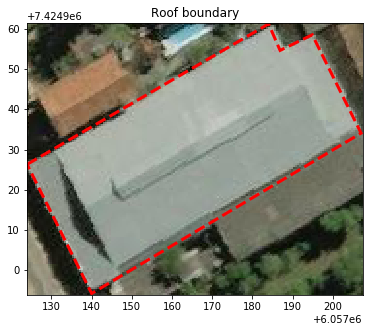

     area: 1941.7m²
   length: 178.3m
Footprint: center:[ 6056326.96  7421622.37] size:[ 52.6   58.39] raster-size:[109 121]


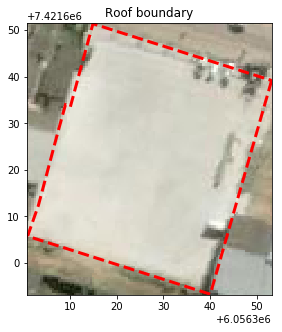

     area: 1893.0m²
   length: 246.69m
Footprint: center:[ 6057352.64  7423870.62] size:[ 60.8   77.69] raster-size:[126 161]


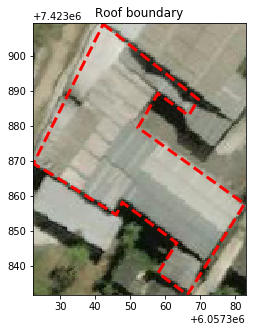

     area: 1503.0m²
   length: 266.21m
Footprint: center:[ 6055139.86  7421389.53] size:[ 67.08  54.05] raster-size:[139 112]


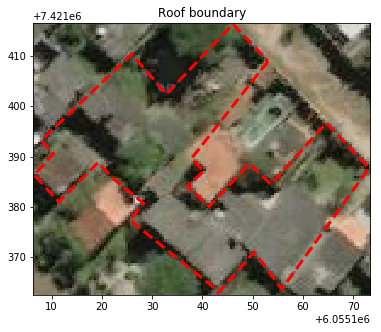

In [2]:
import buzzard as buzz
import numpy as np

import matplotlib.pyplot as plt
import descartes

np.set_printoptions(linewidth=100, threshold=np.inf, precision=2)

rgb_path = paths['3bands_epsg29100'] # From initialization phase
roofs_path = paths['roofs_epsg29100'] # From initialization phase

# Instanciate a DataSource object that will hold pointers to all opened files
# To retrieve the proxy object of a file use its key in one of the getters of DataSource
#   - ds.key (__getattr__ method)
#   - ds['key'] (__getitem__ method)
#   - ds.get('key') (get method)
# -
# Types:
# `ds.rgb` is a RasterProxy
# `ds.roofs` is a VectorProxy
# `ds.rgb.fp` is a Footprint
ds = buzz.DataSource()
ds.open_raster('rgb', rgb_path)
ds.open_vector('roofs', roofs_path)
print('**** rbg ****************')
print(f'    band-count: {len(ds.rgb)}')
print(f'     band-type: {ds.rgb.dtype}')
print(f'   raster-size: {ds.rgb.fp.rsize}')
print(f'geo-transforms: {ds.rgb.fp.gt.tolist()}')
print(f'proj4: {ds.rgb.proj4_origin}')
print('**** roofs **************')
print(f'geometry-count: {len(ds.roofs)} {ds.roofs.type}s')
print(f'        fields: {[(fld["name"], fld["type"]) for fld in ds.roofs.fields]}')
print(f'        extent: {ds.roofs.extent}')
print(f'proj4: {ds.roofs.proj4_origin}\n')

# Retrieve all roofs polygons in file and sort those by area (largest first)
# -
# Types:
# `polygons` from `iter_data` is a generator of shapely.geometry.Polygon
polygons = ds.roofs.iter_data(None)
polygons = sorted(polygons, key=lambda poly: poly.area, reverse=True)

# Iterate over the 4 largest polygons as shapely objects
for polygon_roof in polygons[:4]:

    # Compute the Footprint bounding `polygon_roof` with the Footprint.intersection method
    # -
    # Types:
    # `fp` is a Footprint of size (w, h) aligned with `ds.rgb.fp`
    fp = ds.rgb.fp & polygon_roof

    print(f'     area: {polygon_roof.area:.5}m²')
    print(f'   length: {polygon_roof.length:.5}m')
    print(f'Footprint: center:{fp.c} size:{fp.size} raster-size:{fp.rsize}')

    # Read rgb at `fp`
    # -
    # Types:
    # `rgb` is a numpy.ndarray of shape (h, w, 3) and dtype uint8
    rgb = ds.rgb.get_data(band=(1, 2, 3), fp=fp).astype('uint8')

    # Show image with matplotlib and descartes
    fig = plt.figure(figsize=(5. / fp.height * fp.width, 5))
    plt.title('Roof boundary')
    ax = fig.add_subplot(111)
    ax.imshow(rgb, extent=[fp.lx, fp.rx, fp.by, fp.ty])
    ax.add_patch(descartes.PolygonPatch(polygon_roof, fill=False, ec='#ff0000', lw=3, ls='--'))
    plt.show()

del ds

## Exemple 2: Computing and saving polygon's skeletons

buzzard features:
- Reading vector files with fields
- Creating vector files with fields
- Polygons rasterizing


In [3]:
import buzzard as buzz
import numpy as np
import shapely
import skimage.morphology

rgb_path = paths['3bands_epsg29100'] # From initialization phase
roofs_path = paths['roofs_epsg29100'] # From initialization phase

ds = buzz.DataSource()
ds.open_raster('rgb', rgb_path)
ds.open_vector('roofs', roofs_path)

# Create a MultiLineString shapefile with two fields and register it in
#   datasource under `skeletons` key
# -
# DataSource.create_vector parameters:
#   The first 3 parameters are mandatory: key, path, geometry
#   `fields=()` to define fields
#   `layer=None` to select a layer
#   `driver='ESRI Shapefile` to select the ogr driver to use
#   `options=()` to pass options to the ogr driver
#   `sr=None` to set a spatial reference, any textual spatial reference can be used
#   `key=None` to open the file in DataSource after creation
fields = [
    {'name': 'roof_id', 'type': int},
    {'name': 'compactnes', 'type': float},
]
ds.create_vector('skeletons', './skeleton.shp', 'multilinestring',
                 fields, sr=ds.roofs.proj4_origin)

# Build the list of all features (polygons) larger than 500m² and sorted by compactness
#    `compactness` formula yields a real between 0 and 1 (0 for a line, 1 for a circle).
# -
# Types:
# `features` from `iter_data` is a generator of (shapely.geometry.Polygon, int)
features = ds.roofs.iter_data('FID')
features = (ftr for ftr in features if ftr[0].area > 500)
features = sorted(features, key=lambda ftr: 4 * np.pi / (ftr[0].length ** 2. / ftr[0].area))

# Iterate over the 5 less compact polygons
# -
# Types:
# `polygon_roof` is a shapely.geometry.Polygon
# `fid` is an int
for polygon_roof, fid in features[:5]:

    compactness = 4 * np.pi / (polygon_roof.length ** 2. / polygon_roof.area)
    fp = ds.rgb.fp & polygon_roof

    # Build the skeleton using skimage, scipy.ndimage and shapely
    # -
    # Types:
    # `mask_inside` is a numpy.ndarray of shape (h, w) and dtype bool
    # `binary_skeleton` is a numpy.ndarray of shape (h, w) and dtype bool
    mask_inside = fp.burn_polygons(polygon_roof)
    binary_skeleton = skimage.morphology.skeletonize(mask_inside)
    multiline_skeleton = shapely.geometry.MultiLineString(
        fp.find_lines(binary_skeleton)
    )
    
    # Insert skeleton feature in file
    ds.skeletons.insert_data(multiline_skeleton, [fid, compactness])
    
del ds

### Visualization

  Footprint: center:[ 6057285.08  7424319.4 ] size:[ 39.57  53.56] raster-size:[ 82 111]
    roof_id: 349
       area: 507.2m²
     length: 191.27m
compactness: 17.4%


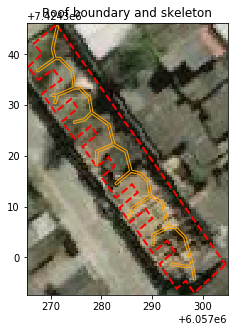

  Footprint: center:[ 6055220.93  7421428.38] size:[ 48.74  48.74] raster-size:[101 101]
    roof_id: 289
       area: 716.85m²
     length: 204.39m
compactness: 21.6%


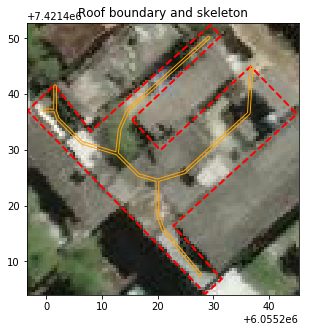

  Footprint: center:[ 6055198.49  7421317.39] size:[ 49.22  73.83] raster-size:[102 153]
    roof_id: 344
       area: 1345.2m²
     length: 253.21m
compactness: 26.4%


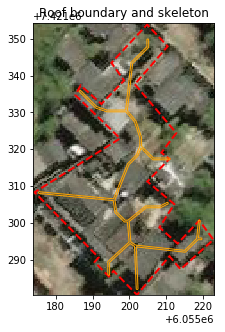

  Footprint: center:[ 6055139.86  7421389.53] size:[ 67.08  54.05] raster-size:[139 112]
    roof_id: 343
       area: 1503.0m²
     length: 266.21m
compactness: 26.7%


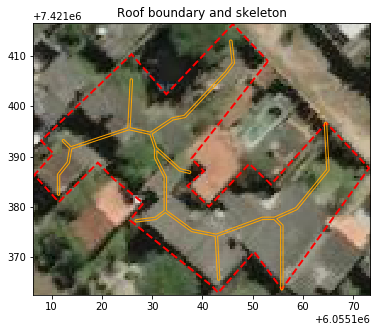

  Footprint: center:[ 6054981.82  7420654.59] size:[ 37.64  35.71] raster-size:[78 74]
    roof_id: 1
       area: 609.81m²
     length: 163.13m
compactness: 28.8%


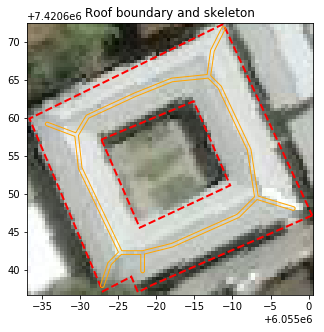

In [4]:
import buzzard as buzz
import matplotlib.pyplot as plt
import descartes
import numpy as np

np.set_printoptions(linewidth=100, threshold=np.inf, precision=2)

rgb_path = paths['3bands_epsg29100'] # From initialization phase
roofs_path = paths['roofs_epsg29100'] # From initialization phase

ds = buzz.DataSource()
ds.open_raster('rgb', rgb_path)
ds.open_vector('roofs', roofs_path)
ds.open_vector('skeletons', './skeleton.shp')

for multiline_skeleton, roof_id, compactness in ds.skeletons.iter_data():

    polygon_roof = ds.roofs.get_data(roof_id, None)
    fp = ds.rgb.fp & polygon_roof
   
    print(f'  Footprint: center:{fp.c} size:{fp.size} raster-size:{fp.rsize}')
    print(f'    roof_id: {roof_id}')
    print(f'       area: {polygon_roof.area:.5}m²')
    print(f'     length: {polygon_roof.length:.5}m')
    print(f'compactness: {compactness:.1%}')
    
    # Read rgb at `fp` to a numpy array
    rgb = ds.rgb.get_data(band=(1, 2, 3), fp=fp).astype('uint8')

    fig = plt.figure(figsize=(5. / fp.height * fp.width, 5))
    plt.title('Roof boundary and skeleton')
    ax = fig.add_subplot(111)
    ax.imshow(rgb, extent=[fp.lx, fp.rx, fp.by, fp.ty])
    ax.add_patch(descartes.PolygonPatch(polygon_roof, fill=False, ec='#ff0000', lw=2, ls='--'))
    ax.add_patch(descartes.PolygonPatch(multiline_skeleton.simplify(fp.pxsizex).buffer(fp.pxsizex / 2), fill=False, ec='orange', lw=1, ls='-'))
    plt.show()
    
del ds

## Exemple 3: Find dense areas and save images highlighting roofs

buzzard features:
- Raster file creation
- Raster file writing with masks and Footprints
- Raster/spatial coordinates conversions with Footprint
- Footprint tiling
- Automatic raster resampling


### Part 1: Open files and build a binary raster containing all roofs

file's Footprint and low-resolution Footprint
          center                  size(m)         raster-size  pixel-size(m) 
 [ 6052631.99  7420424.17] [  9676.78  10473.01] [20053 21703] [ 0.48  0.48]
 [ 6052631.99  7420424.17] [  9676.78  10473.01] [1002 1085]   [ 9.66  9.65]


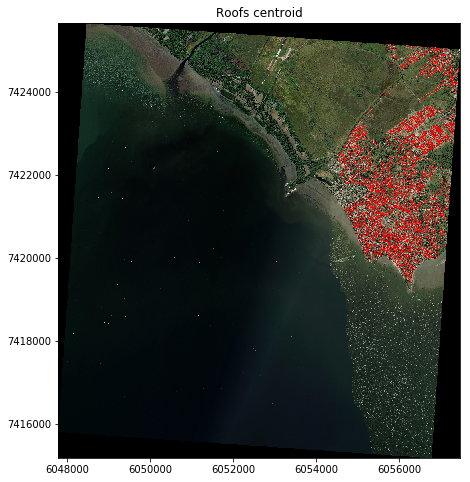

In [5]:
import buzzard as buzz
import numpy as np
import skimage.morphology
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=100, threshold=np.inf, precision=2)

rgb_path = paths['3bands_epsg29100'] # From initialization phase
roofs_tile_path = paths['roofs_epsg29100'] # From initialization phase

# Instanciate a DataSource object with automatic image resampling allowed.
ds = buzz.DataSource(allow_interpolation=True)
ds.open_raster('rgb', rgb_path)
ds.open_vector('roofs', roofs_tile_path)

# Build a low resolution Footprint to perform quicker calculations 
fp_low_res = buzz.Footprint(
    tl=ds.rgb.fp.tl,
    size=ds.rgb.fp.size,
    rsize=ds.rgb.fp.rsize // 20,
)

print("file's Footprint and low-resolution Footprint")
print(' {:^25} {:^21} {:^13} {:^13} '.format('center', 'size(m)', 'raster-size', 'pixel-size(m)'))
print(' {fp.c} {fp.size} {fp.rsize!s:<13} {fp.pxsize}'.format(fp=ds.rgb.fp))
print(' {fp.c} {fp.size} {fp.rsize!s:<13} {fp.pxsize}'.format(fp=fp_low_res))

# Build a low resolution mask containing locations of roofs
# -
# Types:
# `xy_raster` is a numpy.ndarray of shape (2,) and dtype int32
roof_centroids_mask = np.zeros(fp_low_res.shape, dtype=bool)
for polygon_roof in ds.roofs.iter_data(None):
    xy_spatial = np.asarray(polygon_roof.centroid)
    xy_raster = fp_low_res.spatial_to_raster(xy_spatial)
    roof_centroids_mask[xy_raster[1], xy_raster[0]] = True

# Display `roof_centroids_mask` above `rgb`
#    `rgb` is automatically resampled to a lower resolution
rgb = ds.rgb.get_data(band=(1, 2, 3), fp=fp_low_res).astype('uint8')
rgb[roof_centroids_mask] = [255, 0, 0]

fig = plt.figure(figsize=(8. / fp_low_res.height * fp_low_res.width, 8))
plt.title('Roofs centroid')
ax = fig.add_subplot(111)
ax.imshow(rgb, extent=[fp_low_res.lx, fp_low_res.rx, fp_low_res.by, fp_low_res.ty])
plt.show()

### Part 2: Find a dense area and create several `.tif` images

In [6]:
# Build a binary image containing the string "buzzard"
text_mask = exemples.create_text_mask('buzzard', thickness=30, font_scale=10)
red_text = (
    np.repeat(text_mask[..., np.newaxis], 3, -1) * [176, 50, 46]
).astype('uint8')

    
# Tile `ds.rbg.fp` to overlapping tiles of 500 meter width and 250 meter height
# -
# Types:
# `tiles` from `Footprint.tile` is a numpy.ndarray of Footprint
tile_size = (500, 250) // ds.rgb.fp.pxsize
overlap_sizex = 300 // ds.rgb.fp.pxsizex
overlap_sizey = 50 // ds.rgb.fp.pxsizex
tiles = ds.rgb.fp.tile(tile_size, overlap_sizex, overlap_sizey)
print(f'Built {tiles.size} tiles in a matrix of shape {tiles.shape}\n')
tiles = tiles.flatten().tolist()

# Sort tiles by number of roofs inside it
tiles = sorted(
    tiles,
    key=lambda tile: roof_centroids_mask[tile.slice_in(fp_low_res)].sum(),
    reverse=True,
)

# Iterating over the 2 most populated tiles
for tile_i, tile in enumerate(tiles[:2]):

    # Retrieve the polygons from `ds.roofs` inside Footprint 
    #   The `clip` parameter is used to clip polygons partially outside of `tile`
    polygons_roof = list(ds.roofs.iter_data(None, mask=tile, clip=True))
    roof_count = len(polygons_roof)
    print(f'~{roof_count} polygons inside tile')
    
    # Build several masks to highlight roofs
    mask_roofs = tile.burn_polygons(polygons_roof)
    mask_roofs_boundaries = skimage.morphology.dilation(
        mask_roofs ^ skimage.morphology.erosion(mask_roofs)
    )
    binary_skeleton = skimage.morphology.dilation(
        skimage.morphology.skeletonize(mask_roofs)
    )

    yellow_roof_boundaries = (
        np.repeat(mask_roofs_boundaries[..., np.newaxis], 3, -1) * [255, 255, 0]
    ).astype('uint8')
    green_skeleton = (
        np.repeat(binary_skeleton[..., np.newaxis], 3, -1) * [0, 255, 0]
    ).astype('uint8')

    # Create a new file
    # -
    # DataSource.create_raster parameters:
    #   The first 5 parameters are mandatory: key, path, fp, dtype, band_count
    #   `band_schema=None` to set bands attributes
    #   `driver='GTiff'` to select the gdal driver to use
    #   `options=()` to pass options to the gdal driver
    #   `sr=None` to set a spatial reference, any textual spatial reference can be used
    # -
    # A context manager is used to control the opening scope of this file proxy
    with ds.create_raster('output', f'./roofs{tile_i}.tif', tile, 'uint8', 3,
                          band_schema=None, sr=ds.rgb.proj4_origin).close:

        # Basic write: Set the full raster at once with rgb
        # -
        # RasterProxy.set_data parameters:
        #   The first parameter is mandatory: array
        #   `fp=None` location of array in file (should be coherent with `array`)
        #   `band=1` bands to write (should be coherent with `array`)
        #   `interpolation='cv_area'` interpolation to perform if needed
        #   `mask=None` constraint on which pixels are written (should be coherent with `array`)
        #   `op=np.rint` rounding operation following a resampling
        rgb = ds.rgb.get_data(band=-1, fp=tile).astype('uint8')
        ds.output.set_data(rgb, band=-1)

        # Masked write: Add roofs boundaries and skeletons
        ds.output.set_data(yellow_roof_boundaries, band=-1, mask=mask_roofs_boundaries)
        ds.output.set_data(green_skeleton, band=-1, mask=binary_skeleton)

        # Masked write at Footprint with resampling: Add the text in the middle of the file
        text_size = 150 * np.asarray([1, text_mask.shape[0] / text_mask.shape[1]])
        fp_text = buzz.Footprint(
            tl=tile.c - text_size * (0.5, -0.5),
            size=text_size,
            rsize=np.flipud(text_mask.shape),
        )
        print('Footprint-tile and Footprint-text')
        print(' {:^25} {:^21} {:^13} {:^13} '.format('center', 'size(m)', 'raster-size', 'pixel-size(m)'))
        print(' {fp.c} {fp.size!s:21} {fp.rsize!s:<13} {fp.pxsize}'.format(fp=tile))
        print(' {fp.c} {fp.size!s:21} {fp.rsize!s:<13} {fp.pxsize}\n'.format(fp=fp_text))

        ds.output.set_data(red_text, fp=fp_text, band=-1, mask=text_mask)
   

Built 2491 tiles in a matrix of shape (53, 47)

~728 polygons inside tile
Footprint-tile and Footprint-text
          center                  size(m)         raster-size  pixel-size(m) 
 [ 6056855.12  7422932.28] [ 499.93  249.97]     [1036  518]   [ 0.48  0.48]
 [ 6056855.12  7422932.28] [ 150.     30.38]     [1180  239]   [ 0.13  0.13]

~625 polygons inside tile
Footprint-tile and Footprint-text
          center                  size(m)         raster-size  pixel-size(m) 
 [ 6055853.81  7420328.86] [ 499.93  249.97]     [1036  518]   [ 0.48  0.48]
 [ 6055853.81  7420328.86] [ 150.     30.38]     [1180  239]   [ 0.13  0.13]



### Visualization

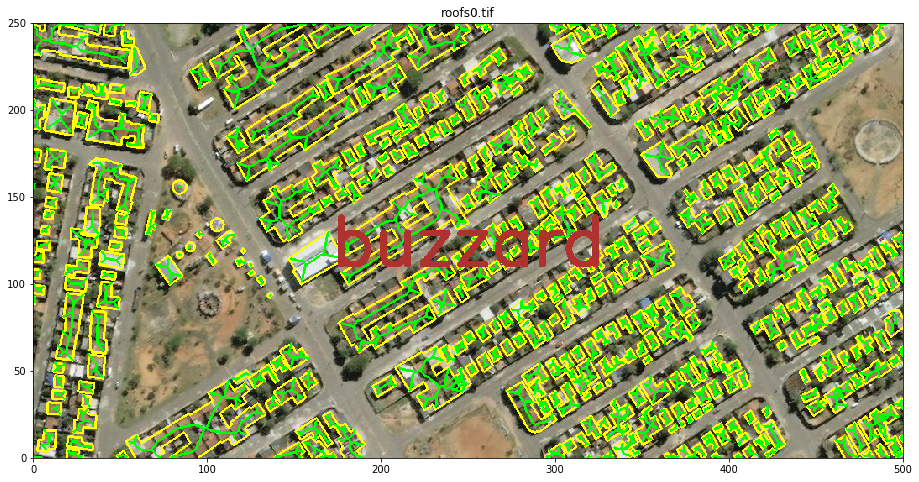

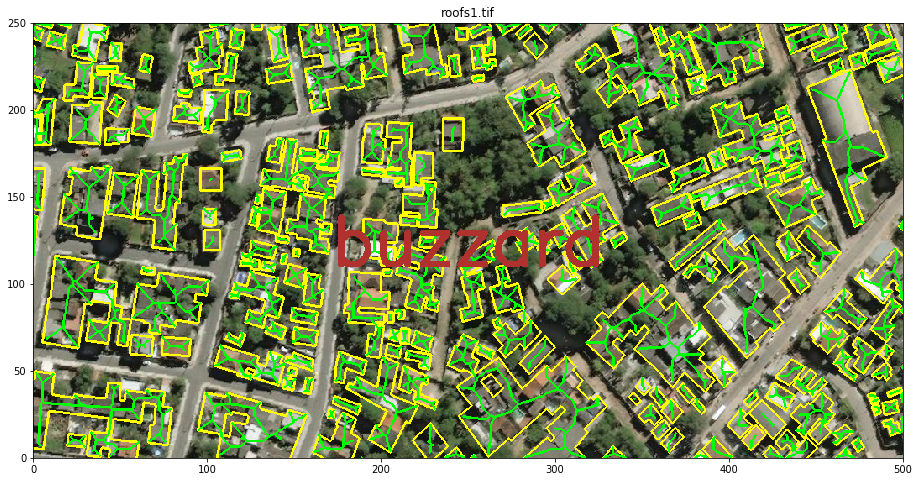

In [10]:
import buzzard as buzz
import matplotlib.pyplot as plt

ds = buzz.DataSource()

for tile_path in ['roofs0.tif', 'roofs1.tif']:
    
    with ds.open_raster('tile', tile_path).close:
        rgb = ds.tile.get_data(band=-1).astype('uint8')
        fp = ds.tile.fp

    fig = plt.figure(figsize=(8. / tile.height * tile.width, 8))
    plt.title(tile_path)
    ax = fig.add_subplot(111)
    ax.imshow(rgb, extent=[0, fp.rx - fp.lx, 0, fp.ty - fp.by])
    plt.show()
